# **Coronavirus Tweets NLP - Text Classification**

This notebook aims at building at text classification engine from the content of Coronavirus Tweets NLP - Text Classifiation dataset that contains around 41157 reviews. Basically, the engine works as follows: after user has provided with tweet, the engine cleans the data and tries to classify the tweet as positive, negative or neutral.

The Notebook is organised as follows.

1.Text Cleaning

*   Removing the URLS
*   Removing HTML tags
*   Removing Numbers/Digits
*   Removing Punctuations
*   Removing Mentions
*   Removing Hash
*   Removing extra spaces

2.Converting Text to Numerical Vector

*   TF-IDF

3.Modeling

*   MultinomialNB
*   Random Forest
*   SGD Classifier
*   XGBoost

4.Conclusion

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [3]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Libraries

In [4]:
# Importing the libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [5]:
train_dataset = pd.read_csv("/content/drive/My Drive/Corona_NLP_train.csv",encoding="latin")
test_dataset = pd.read_csv("/content/drive/My Drive/Corona_NLP_test.csv",encoding="latin")

In [6]:
print(train_dataset.shape)
print(test_dataset.shape)

(41157, 6)
(3798, 6)


In [7]:
print(train_dataset.columns)
print(test_dataset.columns)

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')
Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')


In [8]:
train_dataset["Sentiment"].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

Here, there are five classes:'Neutral, Positive, Extremely Negative, Negative, Extremely Positive'.
Extremely Negative & Negative is encoded as 0.
Extremely Positive & Positive is encoded as 2.
Neutral is encoded as 2.

In [9]:
def classes_def(x):
    if x ==  "Extremely Positive":
        return "2"
    elif x == "Extremely Negative":
        return "0"
    elif x == "Negative":
        return "0"
    elif x ==  "Positive":
        return "2"
    else:
        return "1"
    

train_dataset['class']=train_dataset['Sentiment'].apply(lambda x:classes_def(x))

In [10]:
train_dataset["class"].value_counts(normalize= True)

2    0.438467
0    0.374128
1    0.187404
Name: class, dtype: float64

Text Cleaning

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
from bs4 import BeautifulSoup
STOPWORDS = set(stopwords.words('english'))

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

from tqdm import tqdm
preprocessed_tweets = []
# tqdm is for printing the status bar
for sentance in tqdm(train_dataset['OriginalTweet'].values):
    sentance = re.sub(r'https?://\S+|www\.\S+', r'', sentance) # remove URLS
    sentance = re.sub(r'<.*?>', r'', sentance) # remove HTML
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub(r'\d+', '', sentance).strip() # remove number
    sentance = re.sub(r"[^\w\s\d]","", sentance) # remove pnctuations
    sentance = re.sub(r'@\w+','', sentance) # remove mentions
    sentance = re.sub(r'#\w+','', sentance) # remove hash
    sentance = re.sub(r"\s+"," ", sentance).strip() # remove space
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    
    sentance = ' '.join([e.lower() for e in sentance.split() if e.lower() not in STOPWORDS])
    preprocessed_tweets.append(sentance.strip())

100%|██████████| 41157/41157 [00:15<00:00, 2576.00it/s]


TF-IDF

In information retrieval, tf–idf, TF*IDF, or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today. A survey conducted in 2015 showed that 83% of text-based recommender systems in digital libraries use tf–idf.

In [13]:
tf_idf_vect = TfidfVectorizer(min_df=10)
tf_idf_vect.fit(preprocessed_tweets)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_tweets)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['abc', 'abcnews', 'ability', 'able', 'abroad', 'absence', 'absolute', 'absolutely', 'absurd', 'abt']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (41157, 6611)
the number of unique words including both unigrams and bigrams  6611


In [14]:
X = final_tf_idf
y = train_dataset["class"].tolist()

X_train, X_test, y_train, y_test = train_test_split(X.tocsr(), y, test_size= 0.33, stratify=y,  random_state=42)

Modeling

MultinomialNB

In [15]:
grid_params ={'alpha':[10**x for x in range(-4,4)]}
alpha_log = [math.log(x,10) for x in grid_params["alpha"]]

MultinomialNB_model = GridSearchCV(MultinomialNB(),grid_params,
                     scoring = 'accuracy', cv=10,n_jobs=-1, return_train_score=True)
MultinomialNB_model.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

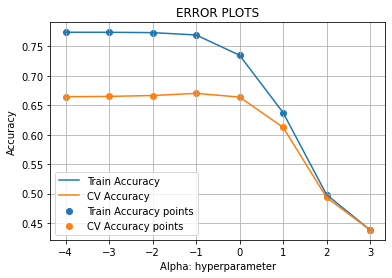

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)


In [16]:
results = pd.DataFrame.from_dict(MultinomialNB_model.cv_results_)
results = results.sort_values(['param_alpha'])

plt.plot(alpha_log, results["mean_train_score"], label='Train Accuracy')
plt.plot(alpha_log, results["mean_test_score"].values, label='CV Accuracy')

plt.scatter(alpha_log, results["mean_train_score"].values, label='Train Accuracy points')
plt.scatter(alpha_log, results["mean_test_score"].values, label='CV Accuracy points')

plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("Accuracy")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()
print(MultinomialNB_model.best_estimator_)

Accuracy: 0.6749374171697835


Text(25.5, 0.5, 'True Value')

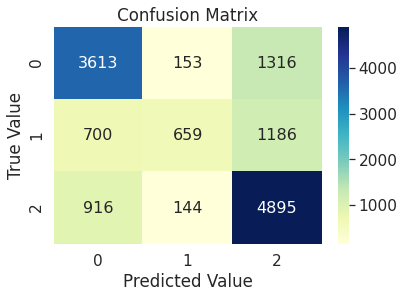

In [17]:
MultinomialNB_model = MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
MultinomialNB_model.fit(X_train,y_train)

y_pred = MultinomialNB_model.predict(X_test)
cm=confusion_matrix(y_test, y_pred)
cm_df=pd.DataFrame(cm,index=[0,1,2],columns=[0,1,2])
print("Accuracy:",accuracy_score(y_test, y_pred))

sns.set(font_scale=1.4,color_codes=True,palette="deep")
sns.heatmap(cm_df,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

In [18]:
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= train_dataset['class'].unique()))

              precision    recall  f1-score   support

           1       0.69      0.71      0.70      5082
           2       0.69      0.26      0.38      2545
           0       0.66      0.82      0.73      5955

    accuracy                           0.67     13582
   macro avg       0.68      0.60      0.60     13582
weighted avg       0.68      0.67      0.65     13582



From the results, we can see that the recall is very low for class 2.

Recall = True Positive/(True Positive + True Negative).

Which implies, 74% tweets indicating Covid-19 Positive but model predicting as Negative or Neutral.

Random Forest

In [19]:
max_depth = [1,5,10,50]
n_estimators = [5,10,100,500]
grid_params ={'max_depth':max_depth,'n_estimators':n_estimators}

RandomFoest_model = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'), grid_params,
                  scoring = 'accuracy', cv=10,n_jobs=-1, return_train_score=True)
RandomFoest_model.fit(X_train, y_train)

results = pd.DataFrame.from_dict(RandomFoest_model.cv_results_)
print(RandomFoest_model.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


Text(0.5, 0, 'Accuracy')

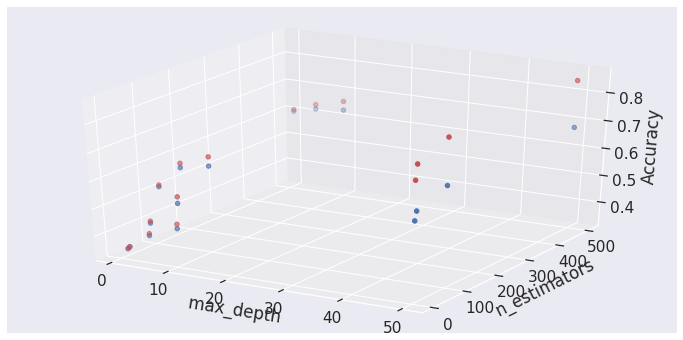

In [20]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

max_depth = [1,1,1,1,5,5,5,5,10,10,10,10,50,50,50,50]
n_estimators = [5,10,100,500,5,10,100,500,5,10,100,500,5,10,100,500]
mean_train_score = list(results["mean_train_score"].values)
mean_test_score = list(results["mean_test_score"].values)

fig = matplotlib.pyplot.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(max_depth, n_estimators, mean_train_score, c='r', marker='o')
ax.scatter(max_depth, n_estimators, mean_test_score, c='b', marker='o')

ax.set_xlabel('max_depth ')
ax.set_ylabel('n_estimators')
ax.set_zlabel('Accuracy')

Accuracy: 0.6862759534678251


Text(25.5, 0.5, 'True Value')

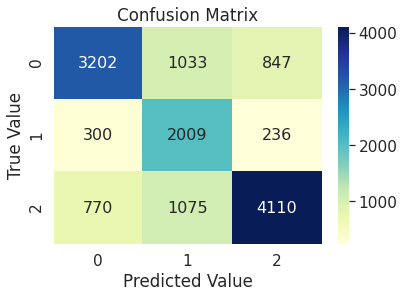

In [21]:
RandomFoest_model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
RandomFoest_model.fit(X_train,y_train)

y_pred = RandomFoest_model.predict(X_test)
cm=confusion_matrix(y_test, y_pred)
cm_df=pd.DataFrame(cm,index=[0,1,2],columns=[0,1,2])
print("Accuracy:",accuracy_score(y_test, y_pred))

sns.set(font_scale=1.4,color_codes=True,palette="deep")
sns.heatmap(cm_df,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

In [22]:
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= train_dataset['class'].unique()))

              precision    recall  f1-score   support

           1       0.75      0.63      0.68      5082
           2       0.49      0.79      0.60      2545
           0       0.79      0.69      0.74      5955

    accuracy                           0.69     13582
   macro avg       0.68      0.70      0.68     13582
weighted avg       0.72      0.69      0.69     13582



From the results, we can see that recall is improved but precision is low for class 2.

Precision = True Positive/(True Positive + False Positive).

Which implies, 42% tweets indicating Covid-19 Negative but model predicting as Positive or Neutral.

Recall and Precision is good for class 1 and 2.

SGD Classifier

In [23]:
alpha = [10**x for x in range(-4,4)]
penalty = ["l1","l2"]
grid_params ={'alpha':alpha,'penalty':penalty}
alpha_log = [math.log(x,10) for x in grid_params["alpha"]]

SGDClassifier_model = GridSearchCV(SGDClassifier(class_weight= 'balanced'), grid_params,
                     scoring = 'accuracy', cv=10,n_jobs=-1, return_train_score=True)
SGDClassifier_model.fit(X_train, y_train)

results = pd.DataFrame.from_dict(SGDClassifier_model.cv_results_)
results = results.sort_values(['param_alpha'])

print(SGDClassifier_model.best_estimator_)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


Accuracy: 0.7735237814754823


Text(25.5, 0.5, 'True Value')

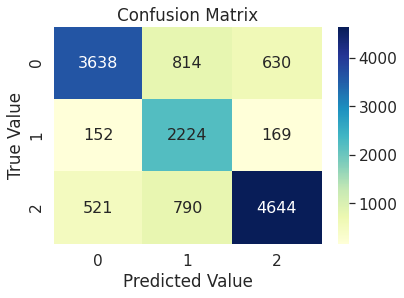

In [24]:
SGDClassifier_model = SGDClassifier(class_weight='balanced', penalty='l1')
SGDClassifier_model.fit(X_train,y_train)

y_pred = SGDClassifier_model.predict(X_test)
cm=confusion_matrix(y_test, y_pred)
cm_df=pd.DataFrame(cm,index=[0,1,2],columns=[0,1,2])
print("Accuracy:",accuracy_score(y_test, y_pred))

sns.set(font_scale=1.4,color_codes=True,palette="deep")
sns.heatmap(cm_df,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

In [25]:
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= train_dataset['class'].unique()))

              precision    recall  f1-score   support

           1       0.84      0.72      0.77      5082
           2       0.58      0.87      0.70      2545
           0       0.85      0.78      0.81      5955

    accuracy                           0.77     13582
   macro avg       0.76      0.79      0.76     13582
weighted avg       0.80      0.77      0.78     13582



From the results, we can see that recall is improved but precision is low for class 2.

Precision = True Positive/(True Positive + False Positive).

Which implies, 42% tweets indicating Covid-19 Negative but model predicting as Positive or Netrual.

Recall and Precision is good for class 1 and 2.

XGBoost

In [29]:
learning_rate = [0.1]
max_depth = [7]
n_estimators = [500]
grid_params ={'max_depth':max_depth,'n_estimators':n_estimators, 'learning_rate':learning_rate}

XGBoost_model = GridSearchCV(XGBClassifier(), grid_params,
                      scoring = 'accuracy', cv=10,n_jobs=-1, return_train_score=True)
XGBoost_model.fit(X_train, y_train)

results = pd.DataFrame.from_dict(XGBoost_model.cv_results_)
print(XGBoost_model.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Accuracy: 0.7786040347518774


Text(25.5, 0.5, 'True Value')

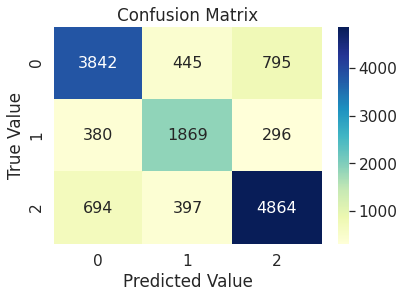

In [30]:
XGBoost_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
XGBoost_model.fit(X_train,y_train)

y_pred = XGBoost_model.predict(X_test)
cm=confusion_matrix(y_test, y_pred)
cm_df=pd.DataFrame(cm,index=[0,1,2],columns=[0,1,2])
print("Accuracy:",accuracy_score(y_test, y_pred))

sns.set(font_scale=1.4,color_codes=True,palette="deep")
sns.heatmap(cm_df,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

In [31]:
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= train_dataset['class'].unique()))

              precision    recall  f1-score   support

           1       0.78      0.76      0.77      5082
           2       0.69      0.73      0.71      2545
           0       0.82      0.82      0.82      5955

    accuracy                           0.78     13582
   macro avg       0.76      0.77      0.77     13582
weighted avg       0.78      0.78      0.78     13582



From the results, we can see that recall & Precision is improved and descent for all classes.

Conclusion

Precision, Recall and F1 score for XGBoost model is descent enough than other models. So will go with XGBoost Model.